# Capstone Project - The Battle of the Neighborhoods (Week 2)
# The best place for a Gym in Toronto by Patrice THIMA

### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* Introduction: Business Problem
* Data
* Methodology
* Analysis
* Results and Discussion
* Conclusion
* References

## Introduction: Business Problem 

For a healthy life, you need to get enough sleep, eat healthy with a balanced diet, and exercise. Workout 3 times a week is a good deal. You can go to a park but sometimes go to the gym is more motivating. By this way, in this project we will try to find the best place to open a **gym** in **Toronto** for a contractor who is trying to start his own business. 

Obviously there already are gyms in **Toronto** so our study consist in finding neighborhood with a lot of gym and also focus on the center of Toronto. It is very important to know why some place have or do not have this activities and understand what type of venues are nearby a gym in order to let the contractor choose the place which it is more effective to start his business.


**With clustering is it possible to segment neighborhoods in order to choose a place for a new gym ?** 



## Data

To answer the question of our problem, we will make a dataframe of the neighborhoods of **Toronto** by scraping a wikipédia page. 

We will obtain the geographical coordinates of **Toronto**  with **Geocoders** and analyse the center of Toronto and classify the most common venues nearby gyms, using **Foursquare API**. We will create many map to represent our data using **Folium**. Because of the **limit** of our account tier we will focus on the center of Toronto to query Foursquare about the gyms.


The data come from a wikipedia page.
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

Another dataset of the geographical coordinate of each neighborhood is here. This data was obtained in the week 3 of the Capstone project.
https://cocl.us/Geospatial_data

Libraries we need.

In [1]:
! pip install lxml

import pandas as pd
import numpy as np

# import k-means from clustering
from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


     |████████████████████████████████| 5.5MB 4.6MB/s eta 0:00:01     |███████████████▏                | 2.6MB 4.6MB/s eta 0:00:01     |███████████████████████▉        | 4.1MB 4.6MB/s eta 0:00:01     |██████████████████████████████  | 5.2MB 4.6MB/s eta 0:00:01


In [3]:
#Geocoders to generate geographical cordinates with address
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported and installed')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0



geopy-2.0.0          | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: d

***We are going to read the page with pandas and extract a list.***

In [2]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
list_wiki=pd.read_html(url)
list_wiki


[    Postal Code           Borough  \
 0           M1A      Not assigned   
 1           M2A      Not assigned   
 2           M3A        North York   
 3           M4A        North York   
 4           M5A  Downtown Toronto   
 ..          ...               ...   
 175         M5Z      Not assigned   
 176         M6Z      Not assigned   
 177         M7Z      Not assigned   
 178         M8Z         Etobicoke   
 179         M9Z      Not assigned   
 
                                          Neighbourhood  
 0                                         Not assigned  
 1                                         Not assigned  
 2                                            Parkwoods  
 3                                     Victoria Village  
 4                            Regent Park, Harbourfront  
 ..                                                 ...  
 175                                       Not assigned  
 176                                       Not assigned  
 177                

***We will convert the list to a dataframe df and change the name of the column "Neighbourhood".***

In [4]:
df=pd.DataFrame(list_wiki[0])
df = df.rename(columns = {"Neighbourhood":"Neighborhood"})
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


## Pre-Processing

*Now let us CLEAN the dataframe by droping the row which contain Not assigned value
after we have replaced Not assigned value to NaN.*

In [5]:
df.replace("Not assigned",np.NaN,inplace=True)

In [6]:
df.dropna(subset=['Borough'],axis=0,inplace=True)
df.reset_index(drop=True)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [7]:
df.shape

(103, 3)

***We will read another dataframe with the geographical coordinates of each postal code and merge it with our first dataframe.***

In [8]:
#Read the new dataframe
df_coord=pd.read_csv('https://cocl.us/Geospatial_data')
df_coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
#Merge the two dataframes
df_merged=df.merge(df_coord)
df_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


**This is a dataframe we will use to solve our problem.** In the next chapter we will focus on the venues around the gyms by this way we will create other dataframe.

## Methodology

We have discussed the business problem and presented the data, now Let's get into the heart of the subject.

In first step we will search all the gyms or Fitness club in the center of toronto and represent them on a map using Folium. Then we will search the most common venues around these gyms and classify this gyms in different Clusters. We will create 5 clusters and try to identify what are the most common venues.

In second step we will classify the neighborhoods of Toronto in others clusters then we will show which clusters of neighborhood have the same common venues of the clusters of the gyms in order to understand what type of cluster are better to start a business, in another word open a Fitness club.
By using Foursquare it is possible to choose **gym** or **Fitness** as query, it will depend which give more answers, in our case this is "Fitness".



With Geolocator we find the coordinates of Toronto then with Foursquare we find the gyms and make dataframe and a map.

## Analysis 

In [10]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [11]:
# Foursquare ID
CLIENT_ID = 'N5EOCZGLTNMAVS24ILL5RLO0NL1X23GHHGE0MJI5Q0LAL3W2' 
CLIENT_SECRET = 'RVFWPINOEXFX2JWCNY1BDRRGQ4SYGRYKJP2FBQHNWDBMLMPR' 
VERSION = '20180605' 
LIMIT = 100 # Foursquare API limit value

With Foursquare we can find a specific venue category within **2000 meters** from the center of toronto.

In [12]:
search_query = 'fitness'
radius = 2000
print(search_query + ' .... OK!')

fitness .... OK!


In [13]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=N5EOCZGLTNMAVS24ILL5RLO0NL1X23GHHGE0MJI5Q0LAL3W2&client_secret=RVFWPINOEXFX2JWCNY1BDRRGQ4SYGRYKJP2FBQHNWDBMLMPR&ll=43.6534817,-79.3839347&v=20180605&query=fitness&radius=2000&limit=100'

We use the get request function and examine the result.

In [14]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5faafc6766505c5f6fc32cac'},
 'response': {'venues': [{'id': '50885719498ea7b5aab3a74c',
    'name': 'GoodLife Fitness Toronto Bell Trinity Centre',
    'location': {'address': '483 Bay St',
     'lat': 43.653436,
     'lng': -79.382314,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.653436,
       'lng': -79.382314}],
     'distance': 130,
     'postalCode': 'M5G 2C9',
     'cc': 'CA',
     'city': 'Toronto',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['483 Bay St', 'Toronto ON M5G 2C9', 'Canada']},
    'categories': [{'id': '4bf58dd8d48988d176941735',
      'name': 'Gym',
      'pluralName': 'Gyms',
      'shortName': 'Gym',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1605041255',
    'hasPerk': False},
   {'id': '4dc842f2e4cd5bc076711d90',
    'name': 'GoodLife Fitness Toronto 137 Yonge Street',
  

The **json** file we obtain is transform into a dataframe.

In [15]:
venues = results['response']['venues']

# tranform venues into a dataframe
df_gym = json_normalize(venues)
df_gym.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,location.neighborhood
0,50885719498ea7b5aab3a74c,GoodLife Fitness Toronto Bell Trinity Centre,"[{'id': '4bf58dd8d48988d176941735', 'name': 'G...",v-1605041255,False,483 Bay St,43.653436,-79.382314,"[{'label': 'display', 'lat': 43.653436, 'lng':...",130,M5G 2C9,CA,Toronto,ON,Canada,"[483 Bay St, Toronto ON M5G 2C9, Canada]",NaN,NaN
1,4dc842f2e4cd5bc076711d90,GoodLife Fitness Toronto 137 Yonge Street,"[{'id': '4bf58dd8d48988d176941735', 'name': 'G...",v-1605041255,False,137 Yonge St,43.651242,-79.378068,"[{'label': 'display', 'lat': 43.651242, 'lng':...",534,M5C 1W6,CA,Toronto,ON,Canada,"[137 Yonge St (at Richmond St), Toronto ON M5C...",at Richmond St,NaN
2,4ff8e46fe4b03705cefc7075,Fitness Centre,"[{'id': '4bf58dd8d48988d176941735', 'name': 'G...",v-1605041255,False,525 Bay St.,43.654690,-79.381739,"[{'label': 'display', 'lat': 43.65469045595554...",222,M5G 2L2,CA,Toronto,ON,Canada,"[525 Bay St. (in Marriott Downtown), Toronto O...",in Marriott Downtown,NaN
3,4c0dca39c700c9b612ffa2dd,GoodLife Fitness Toronto Union Station,"[{'id': '4bf58dd8d48988d176941735', 'name': 'G...",v-1605041255,False,7 Station St,43.644336,-79.383625,"[{'label': 'display', 'lat': 43.644336, 'lng':...",1018,M5J 1C3,CA,Toronto,ON,Canada,"[7 Station St (in Union Station), Toronto ON M...",in Union Station,Entertainment District
4,4bf46261cad2c9289bdc9b99,Deck 27 Pool & Fitness Facility,"[{'id': '4bf58dd8d48988d132951735', 'name': 'H...",v-1605041255,False,33 Gerrard St W,43.658170,-79.383062,"[{'label': 'display', 'lat': 43.65816982438936...",526,NaN,CA,Toronto,ON,Canada,[33 Gerrard St W (in Delta Chelsea on 27th Flo...,in Delta Chelsea on 27th Floor,NaN


**Let us clean this dataframe.**

In [16]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in df_gym.columns if col.startswith('location.')] + ['id']
df_gym_filtered = df_gym.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
df_gym_filtered['categories'] = df_gym_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_gym_filtered.columns = [column.split('.')[-1] for column in df_gym_filtered.columns]

df_gym_filtered.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,GoodLife Fitness Toronto Bell Trinity Centre,Gym,483 Bay St,43.653436,-79.382314,"[{'label': 'display', 'lat': 43.653436, 'lng':...",130,M5G 2C9,CA,Toronto,ON,Canada,"[483 Bay St, Toronto ON M5G 2C9, Canada]",NaN,NaN,50885719498ea7b5aab3a74c
1,GoodLife Fitness Toronto 137 Yonge Street,Gym,137 Yonge St,43.651242,-79.378068,"[{'label': 'display', 'lat': 43.651242, 'lng':...",534,M5C 1W6,CA,Toronto,ON,Canada,"[137 Yonge St (at Richmond St), Toronto ON M5C...",at Richmond St,NaN,4dc842f2e4cd5bc076711d90
2,Fitness Centre,Gym,525 Bay St.,43.654690,-79.381739,"[{'label': 'display', 'lat': 43.65469045595554...",222,M5G 2L2,CA,Toronto,ON,Canada,"[525 Bay St. (in Marriott Downtown), Toronto O...",in Marriott Downtown,NaN,4ff8e46fe4b03705cefc7075
3,GoodLife Fitness Toronto Union Station,Gym,7 Station St,43.644336,-79.383625,"[{'label': 'display', 'lat': 43.644336, 'lng':...",1018,M5J 1C3,CA,Toronto,ON,Canada,"[7 Station St (in Union Station), Toronto ON M...",in Union Station,Entertainment District,4c0dca39c700c9b612ffa2dd
4,Deck 27 Pool & Fitness Facility,Hotel Pool,33 Gerrard St W,43.658170,-79.383062,"[{'label': 'display', 'lat': 43.65816982438936...",526,NaN,CA,Toronto,ON,Canada,[33 Gerrard St W (in Delta Chelsea on 27th Flo...,in Delta Chelsea on 27th Floor,NaN,4bf46261cad2c9289bdc9b99


In [17]:
df_gym_filtered.shape

(50, 16)

Let us **clean** the dataframe.

In [18]:
df_gym_filtered.drop(columns=['labeledLatLngs','cc','country','formattedAddress','crossStreet','city','state','postalCode','id','neighborhood'],inplace=True)
df_gym_filtered.head()

,name,categories,address,lat,lng,distance
0,GoodLife Fitness Toronto Bell Trinity Centre,Gym,483 Bay St,43.653436,-79.382314,130
1,GoodLife Fitness Toronto 137 Yonge Street,Gym,137 Yonge St,43.651242,-79.378068,534
2,Fitness Centre,Gym,525 Bay St.,43.654690,-79.381739,222
3,GoodLife Fitness Toronto Union Station,Gym,7 Station St,43.644336,-79.383625,1018
4,Deck 27 Pool & Fitness Facility,Hotel Pool,33 Gerrard St W,43.658170,-79.383062,526


In [19]:
df_gym_filtered.sort_values(by='distance')

,name,categories,address,lat,lng,distance
25,Busy Bee Fitness Experts,Gym / Fitness Center,319 Merton Street,43.653944,-79.383370,68
0,GoodLife Fitness Toronto Bell Trinity Centre,Gym,483 Bay St,43.653436,-79.382314,130
6,doubletree fitness center (Doubletree Fitness ...,Gym / Fitness Center,108 Chestnut Street,43.654603,-79.386204,221
2,Fitness Centre,Gym,525 Bay St.,43.654690,-79.381739,222
38,Great West Life Fitness Centre,Gym / Fitness Center,02 - 190 Simcoe St,43.652721,-79.381328,226
40,Medx Precision Fitness,Gym,8 Church Street,43.651429,-79.382356,261
5,Fitness Centre,Gym,Sheraton Centre,43.650985,-79.384002,277
42,393 Univ. Ave Fitness Center,Gym / Fitness Center,393 university ave,43.653515,-79.387726,305
8,Google Toronto Fitness Centre,Gym / Fitness Center,"111 Richmond St W, 11F",43.650319,-79.383782,352
43,Toronto Fitness Centre,Gym,NaN,43.653125,-79.388452,365


### Now we can make the map of  the gyms in center of Toronto.

In [108]:
gym_map = folium.Map(location=[latitude, longitude], zoom_start=14) 

# add a red circle marker to represent the center of Toronto
folium.Marker(
    [latitude, longitude],
).add_to(gym_map)

# add the gyms as blue circle markers
for lat, lng, name in zip(df_gym_filtered.lat, df_gym_filtered.lng,df_gym_filtered.name):
    label = folium.Popup(str(name), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='black',
        fill = True,
        popup=label,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(gym_map)
figsize=(15, 10)
# display map
gym_map

As we can see in the center of Toronto there are a lot of gym. It represent in first sight good places for our contractor to start his business. We can also see some gyms are in the same street or not very far, it represent venues with a big attractiveness.
Now we need to focus on this venues around the gyms and try to understand why some area are more attractive.
Let us use Foursquare but this time to obtain common venues around the gyms.

In [28]:
#Create a function to get nearby venues 
def getNearbyVenues(names, latitudes, longitudes, radius=50):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['name', 
                  'Gym Latitude', 
                  'Gym Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Let us create a new dataframe with all venues of the center Toronto  around 50 meters of each gym**

In [29]:
gym_venues=getNearbyVenues(df_gym_filtered['name'],
                df_gym_filtered['lat'],
                df_gym_filtered['lng'],
                radius=300)


GoodLife Fitness Toronto Bell Trinity Centre
GoodLife Fitness Toronto 137 Yonge Street
Fitness Centre
GoodLife Fitness Toronto Union Station
Deck 27 Pool & Fitness Facility
Fitness Centre
doubletree fitness center (Doubletree Fitness Centre)
GoodLife Fitness Toronto Richmond and John
Google Toronto Fitness Centre
GoodLife Fitness
GoodLife Fitness Toronto Wellington and York
GoodLife Fitness Toronto McCaul and Queen
Fitness Centre
GoodLife Fitness Toronto Plaza
GoodLife Fitness Toronto Street Women's Only
Fitness Centre
Festival Tower Fitness Centre & Pool
Fitness Studio
GoodLife Fitness Toronto Richmond and Bathurst
Marriott Toronto City Centre Hotel Fitness Center
Holida Inn Fitness Centre (Holiday Inn Fitness Centre)
Hyatt Regency Fitness Centre
Easy Fitness & Muay Thai Studio
Fitness Centre
Pinnacle Centre Fitness Centre & Pool
Busy Bee Fitness Experts
GoodLife Fitness Toronto Bloor and Park
L3 Level 3 Fitness Club
GoodLife Fitness Toronto Bloor and Bay
FlirtyGirl Fitness
Fitness Ce

In [30]:
gym_venues.head()

,name,Gym Latitude,Gym Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,GoodLife Fitness Toronto Bell Trinity Centre,43.653436,-79.382314,Nathan Phillips Square,43.652270,-79.383516,Plaza
1,GoodLife Fitness Toronto Bell Trinity Centre,43.653436,-79.382314,Indigo,43.653515,-79.380696,Bookstore
2,GoodLife Fitness Toronto Bell Trinity Centre,43.653436,-79.382314,CF Toronto Eaton Centre,43.654447,-79.380952,Shopping Mall
3,GoodLife Fitness Toronto Bell Trinity Centre,43.653436,-79.382314,LUSH,43.653557,-79.380400,Cosmetics Shop
4,GoodLife Fitness Toronto Bell Trinity Centre,43.653436,-79.382314,Downtown Toronto,43.653232,-79.385296,Neighborhood


In [31]:
gym_venues.groupby(by='name').count()

,Gym Latitude,Gym Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
name,,,,,,
393 Univ. Ave Fitness Center,12,12,12,12,12,12
701 fitness centre,54,54,54,54,54,54
Aradia Fitness Toronto,69,69,69,69,69,69
Busy Bee Fitness Experts,38,38,38,38,38,38
Cityplace Fitness Centre,15,15,15,15,15,15
Deck 27 Pool & Fitness Facility,42,42,42,42,42,42
Easy Fitness & Muay Thai Studio,13,13,13,13,13,13
Extreme Fitness Yoga/Hot Yoga Studio,71,71,71,71,71,71
Festival Tower Fitness Centre & Pool,48,48,48,48,48,48


**We will use get_dummies function to encoding the column "Venue Category".**

In [32]:
# one hot encoding
gym_encod = pd.get_dummies(gym_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
gym_encod['name'] = gym_venues['name'] 

gym_encod.head()

,Accessories Store,Afghan Restaurant,American Restaurant,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Bakery,...,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,name
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GoodLife Fitness Toronto Bell Trinity Centre
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GoodLife Fitness Toronto Bell Trinity Centre
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GoodLife Fitness Toronto Bell Trinity Centre
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GoodLife Fitness Toronto Bell Trinity Centre
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GoodLife Fitness Toronto Bell Trinity Centre


**By grouping the Gyms and calculate the mean of each row, we can have the frenquency of each category.**

In [33]:
gym_grouped = gym_encod.groupby('name').mean().reset_index()
gym_grouped.head()

,name,Accessories Store,Afghan Restaurant,American Restaurant,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,393 Univ. Ave Fitness Center,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.083333,0.083333,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
1,701 fitness centre,0.000000,0.0,0.018519,0.0,0.000000,0.0,0.000000,0.000000,0.037037,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.018519,0.018519,0.0,0.018519
2,Aradia Fitness Toronto,0.014493,0.0,0.000000,0.0,0.014493,0.0,0.000000,0.014493,0.028986,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.014493,0.000000,0.0,0.014493
3,Busy Bee Fitness Experts,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.026316,0.000000,0.000000,...,0.0,0.000000,0.026316,0.0,0.026316,0.0,0.000000,0.000000,0.0,0.000000
4,Cityplace Fitness Centre,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.066667,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000


By this way now we can show the 10 most category for each Gym

In [34]:
num_top_venues = 10

for gym in gym_grouped['name']:
    print("----"+gym+"----")
    temp = gym_grouped[gym_grouped['name'] == gym].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 3})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----393 Univ. Ave Fitness Center----
                 venue   freq
0         Neighborhood  0.083
1     Sushi Restaurant  0.083
2                Hotel  0.083
3           University  0.083
4       Breakfast Spot  0.083
5          Coffee Shop  0.083
6           Poke Place  0.083
7             Tea Room  0.083
8  Arts & Crafts Store  0.083
9           Art Museum  0.083


----701 fitness centre----
                  venue   freq
0           Coffee Shop  0.074
1    Italian Restaurant  0.074
2                Bakery  0.056
3                   Bar  0.056
4     Electronics Store  0.037
5  Gym / Fitness Center  0.037
6        Sandwich Place  0.037
7      Asian Restaurant  0.037
8                   Spa  0.037
9                Lounge  0.019


----Aradia Fitness Toronto----
                       venue   freq
0     Furniture / Home Store  0.072
1                Coffee Shop  0.058
2                   Boutique  0.043
3       Gym / Fitness Center  0.043
4                 Restaurant  0.043
5             

Let us make a function to sorted the most common venue nearby each gym.

In [116]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
gym_venues_sorted = pd.DataFrame(columns=columns)
gym_venues_sorted['name'] = gym_grouped['name']

for ind in np.arange(gym_grouped.shape[0]):
    gym_venues_sorted.iloc[ind, 1:] = return_most_common_venues(gym_grouped.iloc[ind, :], num_top_venues)

gym_venues_sorted.head()

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,393 Univ. Ave Fitness Center,Breakfast Spot,Art Museum,Coffee Shop,Sushi Restaurant,University,Arts & Crafts Store,Tea Room,Neighborhood,Ramen Restaurant,Hotel
1,701 fitness centre,Italian Restaurant,Coffee Shop,Bakery,Bar,Sandwich Place,Asian Restaurant,Gym / Fitness Center,Spa,Electronics Store,Men's Store
2,Aradia Fitness Toronto,Furniture / Home Store,Coffee Shop,Restaurant,Boutique,Gym / Fitness Center,Caribbean Restaurant,Middle Eastern Restaurant,Dessert Shop,Theater,Toy / Game Store
3,Busy Bee Fitness Experts,Clothing Store,Hotel,Cosmetics Shop,Electronics Store,Bubble Tea Shop,Breakfast Spot,Shopping Mall,Shoe Store,Seafood Restaurant,Middle Eastern Restaurant
4,Cityplace Fitness Centre,Café,Diner,Historic Site,Park,Grocery Store,Falafel Restaurant,Bank,Train Station,Coffee Shop,Veterinarian


**Now it is time to use KMeans to clustering the different gyms.**

In [124]:
# set number of clusters
kclusters = 5

gym_grouped_clustering = gym_grouped.drop('name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(gym_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 4, 4, 0, 4, 4, 4, 4, 4, 4], dtype=int32)

## We choose arbitrary 5 clusters but let us use the Elbow method to find the best number of clusters.

In [37]:
#Libraries needed 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt 

Distortion: It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used. Inertia: It is the sum of squared distances of samples to their closest cluster center. We iterate the values of k from 1 to 15 and calculate the values of distortions for each value of k and calculate the distortion and inertia for each value of k in the given range.

In [113]:
#Building the clustering model and calculating the values of the Distortion and Inertia
gym_grouped_clustering2=gym_grouped_clustering.copy()

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,7) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k,random_state=0).fit(gym_grouped_clustering2) 
    kmeanModel.fit(gym_grouped_clustering2)     
      
    distortions.append(sum(np.min(cdist(gym_grouped_clustering2, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / gym_grouped_clustering2.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(gym_grouped_clustering2, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / gym_grouped_clustering2.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

### Tabulating and Visualizing the results

1 : 0.17273508499204296
2 : 0.1658526305382929
3 : 0.1575281277162407
4 : 0.14660030732758314
5 : 0.13975402712166188
6 : 0.1384775795355815


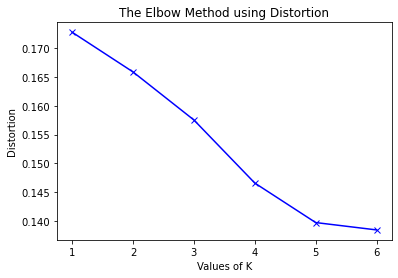

1 : 1.4807815844267442
2 : 1.346985244954235
3 : 1.2024657540034571
4 : 1.0799509756070762
5 : 1.0111874848323732
6 : 0.942001285200522


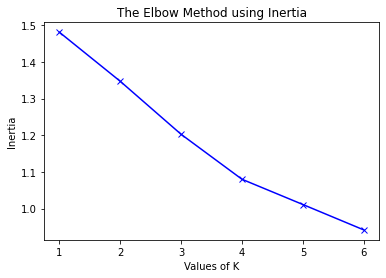

In [114]:

#a) Using the different values of Distortion

for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 


plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 


#b) Using the different values of Inertia


for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 



plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

**Finally we can add the cluster labels in the "df_gym_filtered" dataframe.**

In [119]:
# add clustering labels
gym_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

gym_merged = df_gym_filtered #this is our main dataframe of the gyms after cleaning.

gym_merged = gym_merged.join(gym_venues_sorted.set_index('name'), on='name')

gym_merged.head() 

,name,categories,address,lat,lng,distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,GoodLife Fitness Toronto Bell Trinity Centre,Gym,483 Bay St,43.653436,-79.382314,130,0,Clothing Store,Coffee Shop,Cosmetics Shop,Fast Food Restaurant,Lingerie Store,Gym,Garden,Hotel,Electronics Store,Miscellaneous Shop
1,GoodLife Fitness Toronto 137 Yonge Street,Gym,137 Yonge St,43.651242,-79.378068,534,2,Coffee Shop,Hotel,Italian Restaurant,Clothing Store,Restaurant,Gastropub,Seafood Restaurant,Café,American Restaurant,Japanese Restaurant
2,Fitness Centre,Gym,525 Bay St.,43.654690,-79.381739,222,4,Coffee Shop,Hotel,Clothing Store,Café,Italian Restaurant,Restaurant,Theater,Sushi Restaurant,Pizza Place,Sandwich Place
3,GoodLife Fitness Toronto Union Station,Gym,7 Station St,43.644336,-79.383625,1018,2,Coffee Shop,Hotel,Italian Restaurant,Beer Bar,Park,Plaza,Restaurant,Roof Deck,Salad Place,Café
4,Deck 27 Pool & Fitness Facility,Hotel Pool,33 Gerrard St W,43.658170,-79.383062,526,4,Coffee Shop,Café,Spa,Sandwich Place,Bubble Tea Shop,Burger Joint,Italian Restaurant,Steakhouse,Sporting Goods Shop,Dessert Shop


In [120]:
#looking for null value
gym_merged.isnull().sum()

name                      0
categories                0
address                   6
lat                       0
lng                       0
distance                  0
Cluster Labels            0
1st Most Common Venue     0
2nd Most Common Venue     0
3rd Most Common Venue     0
4th Most Common Venue     0
5th Most Common Venue     0
6th Most Common Venue     0
7th Most Common Venue     0
8th Most Common Venue     0
9th Most Common Venue     0
10th Most Common Venue    0
dtype: int64

**Finally we will create the map of the gyms in the center of Toronto with cluste.**

In [43]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

# set color scheme for each cluster
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(gym_merged['lat'], gym_merged['lng'], gym_merged['name'], gym_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
# add a red circle marker to represent the center of Toronto
folium.Marker(
    [latitude, longitude],   
).add_to(map_clusters)
       
map_clusters

## Cluster 0

In [125]:
gym_merged.loc[gym_merged['Cluster Labels'] == 0, gym_merged.columns[[1] + list(range(5, gym_merged.shape[1]))]]

,categories,distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Gym,130,0,Clothing Store,Coffee Shop,Cosmetics Shop,Fast Food Restaurant,Lingerie Store,Gym,Garden,Hotel,Electronics Store,Miscellaneous Shop
9,Gym,386,0,Clothing Store,Hotel,Coffee Shop,Cosmetics Shop,Restaurant,Gym,Seafood Restaurant,Breakfast Spot,Lingerie Store,American Restaurant
25,Gym / Fitness Center,68,0,Clothing Store,Hotel,Cosmetics Shop,Electronics Store,Bubble Tea Shop,Breakfast Spot,Shopping Mall,Shoe Store,Seafood Restaurant,Middle Eastern Restaurant
38,Gym / Fitness Center,226,0,Clothing Store,Coffee Shop,Hotel,Cosmetics Shop,Theater,Garden,Lingerie Store,Seafood Restaurant,Fast Food Restaurant,Restaurant
40,Gym,261,0,Clothing Store,Coffee Shop,American Restaurant,Restaurant,Asian Restaurant,Office,Thai Restaurant,Garden,Breakfast Spot,Seafood Restaurant
46,Athletics & Sports,487,0,Clothing Store,Coffee Shop,Hotel,Restaurant,Italian Restaurant,American Restaurant,Gym,Japanese Restaurant,Seafood Restaurant,Lingerie Store


## Cluster 1

In [45]:
gym_merged.loc[gym_merged['Cluster Labels'] == 1, gym_merged.columns[[1] + list(range(5, gym_merged.shape[1]))]]

,categories,distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Gym / Fitness Center,221,1,Neighborhood,Art Museum,Sushi Restaurant,Miscellaneous Shop,Seafood Restaurant,Café,Tea Room,Dessert Shop,Poke Place,Ramen Restaurant
42,Gym / Fitness Center,305,1,Breakfast Spot,Art Museum,Coffee Shop,Sushi Restaurant,University,Arts & Crafts Store,Tea Room,Neighborhood,Ramen Restaurant,Hotel
43,Gym,365,1,Coffee Shop,Art Museum,Park,Café,Breakfast Spot,University,Arts & Crafts Store,Neighborhood,Movie Theater,Jazz Club
44,Gym / Fitness Center,423,1,Café,Poke Place,Pub,Hotel,Ramen Restaurant,Movie Theater,Art Museum,French Restaurant,Coffee Shop,Breakfast Spot


## Cluster 2

In [46]:
gym_merged.loc[gym_merged['Cluster Labels'] == 2, gym_merged.columns[[1] + list(range(5, gym_merged.shape[1]))]]

,categories,distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Gym,534,2,Coffee Shop,Hotel,Italian Restaurant,Clothing Store,Restaurant,Gastropub,Seafood Restaurant,Café,American Restaurant,Japanese Restaurant
3,Gym,1018,2,Coffee Shop,Hotel,Italian Restaurant,Beer Bar,Park,Plaza,Restaurant,Roof Deck,Salad Place,Café
10,Gym,783,2,Coffee Shop,Restaurant,Italian Restaurant,Bar,Pizza Place,Deli / Bodega,Pharmacy,Concert Hall,Clothing Store,Chinese Restaurant
13,Gym,601,2,Coffee Shop,Hotel,Italian Restaurant,American Restaurant,Café,Seafood Restaurant,Gym,Breakfast Spot,Restaurant,Deli / Bodega
14,Gym,676,2,Hotel,Coffee Shop,Italian Restaurant,Café,Gastropub,Restaurant,American Restaurant,Japanese Restaurant,Breakfast Spot,Cocktail Bar
17,Gym / Fitness Center,1147,2,Hotel,Aquarium,Coffee Shop,Italian Restaurant,Beer Bar,IT Services,Restaurant,Park,Roof Deck,Salad Place
19,Gym / Fitness Center,1401,2,Coffee Shop,Hotel,Pizza Place,Grocery Store,Gym,Baseball Stadium,Light Rail Station,Ice Cream Shop,Restaurant,Falafel Restaurant
29,Gym / Fitness Center,1523,2,Italian Restaurant,Restaurant,Coffee Shop,Beer Bar,Peruvian Restaurant,Park,Donut Shop,Sandwich Place,Seafood Restaurant,French Restaurant
41,Gym / Fitness Center,633,2,Coffee Shop,Deli / Bodega,Café,Salad Place,Hotel,Seafood Restaurant,Gastropub,Thai Restaurant,Bar,Bank


## Cluster 3

In [47]:
gym_merged.loc[gym_merged['Cluster Labels'] == 3, gym_merged.columns[[1] + list(range(5, gym_merged.shape[1]))]]

,categories,distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Gym / Fitness Center,1870,3,Coffee Shop,Grocery Store,Restaurant,Food Truck,Pool,Fast Food Restaurant,Pharmacy,Park,Performing Arts Venue,Food Court


## Cluster 4

In [48]:
gym_merged.loc[gym_merged['Cluster Labels'] == 4, gym_merged.columns[[1] + list(range(5, gym_merged.shape[1]))]]

,categories,distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Gym,222,4,Coffee Shop,Hotel,Clothing Store,Café,Italian Restaurant,Restaurant,Theater,Sushi Restaurant,Pizza Place,Sandwich Place
4,Hotel Pool,526,4,Coffee Shop,Café,Spa,Sandwich Place,Bubble Tea Shop,Burger Joint,Italian Restaurant,Steakhouse,Sporting Goods Shop,Dessert Shop
5,Gym,277,4,Coffee Shop,Hotel,Clothing Store,Café,Italian Restaurant,Restaurant,Theater,Sushi Restaurant,Pizza Place,Sandwich Place
7,Gym,832,4,Coffee Shop,Italian Restaurant,Bar,Bistro,Bookstore,Boutique,Burrito Place,Event Space,Clothing Store,Pizza Place
8,Gym / Fitness Center,352,4,Coffee Shop,Salad Place,Asian Restaurant,Hotel,Café,Bar,Seafood Restaurant,Thai Restaurant,Japanese Restaurant,Pizza Place
11,Gym,530,4,Sandwich Place,Coffee Shop,Park,Boutique,Arts & Crafts Store,Japanese Restaurant,Ramen Restaurant,Yoga Studio,Burrito Place,Café
12,Athletics & Sports,914,4,Coffee Shop,Hotel,Clothing Store,Café,Italian Restaurant,Restaurant,Theater,Sushi Restaurant,Pizza Place,Sandwich Place
15,Gym,1083,4,Coffee Shop,Hotel,Clothing Store,Café,Italian Restaurant,Restaurant,Theater,Sushi Restaurant,Pizza Place,Sandwich Place
16,Gym / Fitness Center,858,4,Hotel,Restaurant,Pizza Place,Coffee Shop,Movie Theater,Event Space,Fast Food Restaurant,Café,Burrito Place,Bar
18,Gym,1678,4,Bar,Coffee Shop,Furniture / Home Store,Restaurant,Spa,Italian Restaurant,Asian Restaurant,Gym / Fitness Center,Boutique,Café


In [127]:
gym_merged.loc[gym_merged['Cluster Labels'] == 4, gym_merged.columns[[1] + list(range(5, gym_merged.shape[1]))]]['1st Most Common Venue'].value_counts()

Coffee Shop               16
Café                       4
Italian Restaurant         2
Sandwich Place             1
Furniture / Home Store     1
Restaurant                 1
Yoga Studio                1
Sporting Goods Shop        1
Hotel                      1
Bar                        1
Sushi Restaurant           1
Name: 1st Most Common Venue, dtype: int64

## As we can see the **Cluster 4** is the biggest and the most common venues is **Coffee Shop**.

***Now we will classify the neighborhoods of Toronto in clusters.***
Let us recall the dataframe of the neighborhood of Toronto "**df_merged**".

In [49]:
df_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [50]:
def getNearbyVenues2(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Let us create a new dataframe with all neighborhoods of Toronto and the top venues around 500 meters.**

In [51]:
toronto_venues=getNearbyVenues2(df_merged['Neighborhood'],
                df_merged['Latitude'],
                df_merged['Longitude'],
                radius=500)


Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [52]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


**As we did it for venue around the gyms, we will use get_dummies function to encoding the column "Venue Category" of toronto_venues dataframe.**

In [54]:
# one hot encoding
toronto_encod = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_encod['Neighborhood'] = toronto_venues['Neighborhood'] 

toronto_encod.head()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**By grouping the Neighborhood and calculate the mean of each row, we can have the frenquency of each category.**

In [55]:
toronto_grouped = toronto_encod.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


By this way now we can show the 10 most category for each neighborhood

In [56]:
num_top_venues = 10

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 3})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                             venue  freq
0                   Clothing Store   0.2
1                   Breakfast Spot   0.2
2                           Lounge   0.2
3                     Skating Rink   0.2
4        Latin American Restaurant   0.2
5                Accessories Store   0.0
6              Monument / Landmark   0.0
7  Molecular Gastronomy Restaurant   0.0
8       Modern European Restaurant   0.0
9                Mobile Phone Shop   0.0


----Alderwood, Long Branch----
                      venue   freq
0               Pizza Place  0.286
1                       Gym  0.143
2               Coffee Shop  0.143
3                       Pub  0.143
4                  Pharmacy  0.143
5            Sandwich Place  0.143
6  Mediterranean Restaurant  0.000
7               Men's Store  0.000
8             Metro Station  0.000
9            Medical Center  0.000


----Bathurst Manor, Wilson Heights, Downsview North----
                venue   freq
0                Bank  0.0

A function to sorted the most common venue for each neighborhood.

In [75]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Clothing Store,Breakfast Spot,Event Space,Falafel Restaurant,Ethiopian Restaurant,Escape Room,Discount Store
1,"Alderwood, Long Branch",Pizza Place,Sandwich Place,Coffee Shop,Pub,Pharmacy,Gym,Greek Restaurant,Discount Store,Department Store,Dessert Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pharmacy,Ice Cream Shop,Bridal Shop,Shopping Mall,Sandwich Place,Diner,Restaurant,Middle Eastern Restaurant
3,Bayview Village,Japanese Restaurant,Café,Chinese Restaurant,Bank,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Greek Restaurant,Thai Restaurant,Locksmith,Liquor Store,Comfort Food Restaurant,Juice Bar,Butcher


In [76]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

**Finally we can add the cluster labels in the toronto_merged dataframe.**

In [77]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_merged #remember this is our main dataframe with postal code and borough.

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() 

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,Park,Food & Drink Shop,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,Pizza Place,Hockey Arena,Coffee Shop,Portuguese Restaurant,Intersection,Construction & Landscaping,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Escape Room
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.0,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Café,Theater,Spa,Brewery,Shoe Store
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,Clothing Store,Accessories Store,Boutique,Gift Shop,Furniture / Home Store,Event Space,Coffee Shop,Women's Store,Vietnamese Restaurant,Airport Service
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.0,Coffee Shop,Yoga Studio,College Auditorium,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Café,Restaurant,Chinese Restaurant


***The data in the column Cluster Labels are not integer. We already try to convert them but there are some NaN values.
I do not show this part, let us directly fix this problem.***

In [78]:
toronto_merged.isnull().sum()

Postal Code               0
Borough                   0
Neighborhood              0
Latitude                  0
Longitude                 0
Cluster Labels            3
1st Most Common Venue     3
2nd Most Common Venue     3
3rd Most Common Venue     3
4th Most Common Venue     3
5th Most Common Venue     3
6th Most Common Venue     3
7th Most Common Venue     3
8th Most Common Venue     3
9th Most Common Venue     3
10th Most Common Venue    3
dtype: int64

***As we can see, there are 3 neighborhood with NaN, we will drop this rows.
It is probably when we call foursquare, there was no answer about this 3 neighborhoods.***

In [79]:
toronto_merged.dropna(subset=['Cluster Labels'],axis=0,inplace=True)
toronto_merged.reset_index(drop=True)

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,Park,Food & Drink Shop,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,Pizza Place,Hockey Arena,Coffee Shop,Portuguese Restaurant,Intersection,Construction & Landscaping,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Escape Room
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.0,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Café,Theater,Spa,Brewery,Shoe Store
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,Clothing Store,Accessories Store,Boutique,Gift Shop,Furniture / Home Store,Event Space,Coffee Shop,Women's Store,Vietnamese Restaurant,Airport Service
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.0,Coffee Shop,Yoga Studio,College Auditorium,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Café,Restaurant,Chinese Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,1.0,River,Pool,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
96,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,1.0,Coffee Shop,Gay Bar,Japanese Restaurant,Sushi Restaurant,Restaurant,Yoga Studio,Mediterranean Restaurant,Café,Pub,Hotel
97,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,1.0,Pizza Place,Auto Workshop,Garden Center,Garden,Light Rail Station,Fast Food Restaurant,Farmers Market,Comic Shop,Park,Recording Studio
98,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,3.0,Construction & Landscaping,Baseball Field,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store


In [80]:
toronto_merged.isnull().sum()

Postal Code               0
Borough                   0
Neighborhood              0
Latitude                  0
Longitude                 0
Cluster Labels            0
1st Most Common Venue     0
2nd Most Common Venue     0
3rd Most Common Venue     0
4th Most Common Venue     0
5th Most Common Venue     0
6th Most Common Venue     0
7th Most Common Venue     0
8th Most Common Venue     0
9th Most Common Venue     0
10th Most Common Venue    0
dtype: int64

***After cleaning the ultimate dataframe with cluster labels, let us create the map.***

**We need to convert the cluster labels column to int, actually it is float.**

In [81]:
#Convert float to int
toronto_merged['Cluster Labels']=toronto_merged['Cluster Labels'].astype(int)

In [100]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for each cluster
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Neighborhood Cluster 0

In [84]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,0,Park,Food & Drink Shop,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store
21,Caledonia-Fairbanks,0,Park,Women's Store,Pool,Yoga Studio,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
35,"East Toronto, Broadview North (Old East York)",0,Intersection,Park,Convenience Store,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
61,Lawrence Park,0,Park,Swim School,Bus Line,Yoga Studio,Drugstore,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
64,Weston,0,Park,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
66,York Mills West,0,Park,Convenience Store,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
68,"Forest Hill North & West, Forest Hill Road Park",0,Trail,Park,Sushi Restaurant,Jewelry Store,Yoga Studio,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
85,"Milliken, Agincourt North, Steeles East, L'Amo...",0,Playground,Park,Bakery,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
91,Rosedale,0,Park,Playground,Trail,Yoga Studio,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant


## Neighborhood Cluster 1

In [85]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,1,Pizza Place,Hockey Arena,Coffee Shop,Portuguese Restaurant,Intersection,Construction & Landscaping,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Escape Room
2,"Regent Park, Harbourfront",1,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Café,Theater,Spa,Brewery,Shoe Store
3,"Lawrence Manor, Lawrence Heights",1,Clothing Store,Accessories Store,Boutique,Gift Shop,Furniture / Home Store,Event Space,Coffee Shop,Women's Store,Vietnamese Restaurant,Airport Service
4,"Queen's Park, Ontario Provincial Government",1,Coffee Shop,Yoga Studio,College Auditorium,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Café,Restaurant,Chinese Restaurant
6,"Malvern, Rouge",1,Fast Food Restaurant,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Health & Beauty Service
...,...,...,...,...,...,...,...,...,...,...,...,...
97,"First Canadian Place, Underground city",1,Coffee Shop,Café,Gym,Japanese Restaurant,Restaurant,Hotel,Salad Place,Seafood Restaurant,Deli / Bodega,American Restaurant
98,"The Kingsway, Montgomery Road, Old Mill North",1,River,Pool,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
99,Church and Wellesley,1,Coffee Shop,Gay Bar,Japanese Restaurant,Sushi Restaurant,Restaurant,Yoga Studio,Mediterranean Restaurant,Café,Pub,Hotel
100,"Business reply mail Processing Centre, South C...",1,Pizza Place,Auto Workshop,Garden Center,Garden,Light Rail Station,Fast Food Restaurant,Farmers Market,Comic Shop,Park,Recording Studio


## Neighborhood Cluster 2

In [86]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,"West Deane Park, Princess Gardens, Martin Grov...",2,Print Shop,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio,Dim Sum Restaurant


## Neighborhood Cluster 3

In [87]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"Rouge Hill, Port Union, Highland Creek",3,Construction & Landscaping,Bar,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
49,"North Park, Maple Leaf Park, Upwood Park",3,Bakery,Park,Construction & Landscaping,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
101,"Old Mill South, King's Mill Park, Sunnylea, Hu...",3,Construction & Landscaping,Baseball Field,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store


## Neighborhood Cluster 4

In [88]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,"Humberlea, Emery",4,Baseball Field,Yoga Studio,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Field


Let us take a look at the cluster with the most common venue Neighborhood Cluster 1.

In [89]:
neigh_cluster1=(toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]).copy()

In [90]:
neigh_cluster1[['1st Most Common Venue']].value_counts().head()

1st Most Common Venue
Coffee Shop              21
Pizza Place              12
Café                      6
Grocery Store             5
Gym                       3
dtype: int64

As we can see, in the Neighborhood cluster 1, the 1st most common venue is Coffee Shop. In the last study we saw the best cluster for a gym have got to have **Coffee shop** or **Clothing shop** as 1st common venue.
On the map which represent the different Neighborhood Cluster we can vizualise the best neighborhood to open a gym.

### Let us create an ultimate map with Neighborhood Cluster 1 with only neighborhood which have for 1st most common venue "**Coffee Shop**".

In [91]:
coffee_shop=toronto_merged[['Neighborhood','1st Most Common Venue','Latitude','Longitude']].copy()
coffee_shop=coffee_shop.loc[coffee_shop['1st Most Common Venue']=='Coffee Shop']
coffee_shop.reset_index(drop=True)

,Neighborhood,1st Most Common Venue,Latitude,Longitude
0,"Regent Park, Harbourfront",Coffee Shop,43.654260,-79.360636
1,"Queen's Park, Ontario Provincial Government",Coffee Shop,43.662301,-79.389494
2,"Garden District, Ryerson",Coffee Shop,43.657162,-79.378937
3,St. James Town,Coffee Shop,43.651494,-79.375418
4,Berczy Park,Coffee Shop,43.644771,-79.373306
5,Woburn,Coffee Shop,43.770992,-79.216917
6,Leaside,Coffee Shop,43.709060,-79.363452
7,Central Bay Street,Coffee Shop,43.657952,-79.387383
8,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,43.754328,-79.442259
9,"Richmond, Adelaide, King",Coffee Shop,43.650571,-79.384568


In [122]:
coffee_map = folium.Map(location=[latitude, longitude], zoom_start=11) 

# add a red circle marker to represent the center of Toronto
folium.Marker(
    [latitude, longitude],
).add_to(coffee_map)

# add the gyms as blue circle markers
for lat, lng ,neigh in zip(coffee_shop.Latitude, coffee_shop.Longitude, coffee_shop.Neighborhood):
    label = folium.Popup(str(neigh), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='black',
        fill = True,
        popup=label,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(coffee_map)

# display map
coffee_map



## Results and Discussion 

We focus our analysis on the center of Toronto to understand  where there are gyms and around what type of venue.
As we can see the **Cluster 4** is the biggest and the most common venues are **Clothing Store** and **Coffee Shop**. The others clusters as the same most common venues but in these cases the number one is **Coffee Shop**. Coffee Shop seems to be a very important venue nearby gyms.

This analysis of the gyms is about the center of Toronto, it could be good to make a similar analysis for all the neighborhood of Toronto and all the gyms in Toronto but because of limit of time and our Foursquare account limit, this deep analysis was not possible.

About the neighborhood of Toronto the **Neighborhood Cluster 1** is the best cluster for gyms.
Obviously the common venues are not the only parameters to start a business in a city but our analysis gave relevant informations about this subject.

## Conclusion

If our contractor want to start a business as a gym, we find a path to do it.
Purpose of this project was to identify the best neighborhood to start a business. Our analysis gave very interesting informations to choose a good neighborhood. Of course this analysis can be complete with another which manage parameters like concurrency, the cost of business in different neighborhood and the management of the gym. In any case we can conclude that in first approach, our contractor can vizualise our ultimate map to identify neighborhood to start his business, it is nearby Coffee Shop. We can explain this , gym, sport, workout are good thing for mind and the body but sometimes we need motivation to go to the gym. Coffee shop is a venue with big attendance and in my opinion you have more chance to get subscribers nearby them.

## References:

* Neighborhood of Toronto - Wikipedia
* Foursquare API
* Google Map
